# Use the process of BERTopic for topic modeling
Source link: https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6

* Not directly use BERTopic
* But a combination of BERT, UMAP and HDBSCAN
*  Step 1: use BERT to create word embeddings
* Step 2: use UMAP reduce dimensionality
* Step 3: use HDBSCAN to form clusters

In [1]:
import pandas as pd
import numpy as np
from os import listdir
import re, string
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer
import umap
import hdbscan
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [39]:
# load one file
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# load all the files in a directory
def process_docs(directory):
    filenames = list()
    docs = list()
    for filename in listdir(directory):
        path = directory + '/' + filename
        # load document
        filenames.append(filename)
        docs.append(load_doc(path))
    print('Loaded %d files' % len(filenames))
    return filenames, docs

# load both txt and ann files and put them in a dataframe sorted by id
def build_df(directory):
    filenames,docs = process_docs(directory)
    df = pd.DataFrame(list(zip(filenames, docs)), columns=['filename','content'])
    df['id'] = df.filename.apply(lambda x: x.split('.')[0])
    df['ext'] = df.filename.apply(lambda x: x.split('.')[1])
    df = df.pivot(index='id',columns='ext')
    df.columns = ['filename_ann','filename_txt','content_ann','content_txt']
    df = df.reset_index()
    df = df.sort_values(by=['id'],ignore_index=True)
    return df

# text cleaning
# Make text lowercase, remove text in square brackets, remove punctuation, remove words containing numbers, remove line breaks.
def clean_text(text):
    text = text.lower() #Make text lowercase
    text = re.sub(r'\[.*?\]', ' ', text) #remove text in square brackets,
    text = re.sub(r'[%s]' % re.escape(string.punctuation), ' ', text) #remove punctuation
    text = re.sub(r'\w*\d\w*', ' ', text) #remove words containing numbers
    text = re.sub(r'\n', ' ', text) #remove line breaks
    return text

# text lemmatization
#nlp = spacy.load('en')
#def lemmatizer(text):        
#    sent = []
#    doc = nlp(text)
#    for word in doc:
#        sent.append(word.lemma_)
#    output = " ".join(sent)
#    output = re.sub('-PRON-', '', output)
#    return output

# preprocess text, cleaning and lemmatization
# removed lemmatization because word embeddings take care of that
def text_preprocess(text):
    text_clean = clean_text(text)
#    text_lemmatized = lemmatizer(text_clean)
#    return text_lemmatized
    return text_clean

# create a new column with preprocessed text
def column_preprocess(df, col):
    data_list = df[col].values.tolist()
    data_lemmatized = [text_preprocess(data) for data in data_list]

    #add the processed content as a new column to the dataframe
    df[col + '_preprocessed'] = data_lemmatized
    return df


# find the potential field names from the original uncleaned text, 
# which were marked with a : at the end of the line
def find_field_names(df, col):
    field_names = set()
    for row in df[col]:
        row_sentences = list(row.split('\n'))
        row_sentences = [sentence for sentence in row_sentences if sentence!='']
        new_field_names = [sentence[:-1] for sentence in row_sentences if sentence[-1]==':']
        field_names = field_names.union(new_field_names)
    field_names = list(field_names)
    
    percent = []
    for field_name in field_names:
        count = 0
        for row in df[col]:
            if field_name in row:
                 count = count+1 
        current_percent = count/df.shape[0]*100
        percent.append(current_percent)
    df = pd.DataFrame(list(zip(field_names, percent)), columns = ['field_name', 'percent'])
    df = df.sort_values('percent',ascending = False,ignore_index=True)
    
    plt.figure(figsize=(20, 4))
    plt.plot(df.percent)
    plt.xlabel('index of stop words')
    plt.ylabel('percentage of  occurance in all the files')
    plt.show()
    return df

# extract content by a keyword
# the content should start at the location where there is keyword:, eg, 'Chief Complaint:'
# It continues search for the next line that has another keyword from a keyword list, or until the end of the file
# the keep the content in between 

KEYWORD_LIST = ['Admission Date', 'Discharge Date', 'Date of Birth', 'Sex','Service', 'Allergies', 'Attending', 
                'Chief Complaint', 'Major Surgical or Invasive Procedure', 'History of Present Illness', 
                'Past Medical History', 'Social History', 'Family History', 'Physical Exam', 
                'Pertinent Results', 'Brief Hospital Course','Medications on Admission', 
                'Discharge Medications', 'Discharge Disposition', 'Facility', 
                'Discharge Diagnosis', 'Discharge Condition', 'Discharge Instructions', 
                'Followup Instructions','PHYSICAL EXAMINATION ON ADMISSION', 'History of the Present Illness',
               'LABORATORY DATA', 'HOSPITAL COURSE', 'DISPOSITION', 'MAJOR PROCEDURES', 'CONDITION ON DISCHARGE',
               'Addendum', 'DISCHARGE SUMMARY ADDENDUM','DISCHARGE DIAGNOSES']

# After comparing the stop_words list from nltk, word cloud and sklearn, 
# slkean has the most extensive list, thus was chosen as the default stop_words list
# then add keyword_list to the stop_words
def default_stop_words():
    stop_words = text.ENGLISH_STOP_WORDS
    keyword_list = [keyword.lower() for keyword in KEYWORD_LIST]
    keyword_list = [text_preprocess(keyword) for keyword in KEYWORD_LIST]
    stop_words = stop_words.union(keyword_list)
    return stop_words

def extract_by_keyword(original_text, keyword):
    # make everything lowercase
    original_lower = original_text.lower()
    
    keyword = keyword.lower()
    if keyword[-1] != ':':
        keyword = keyword + ':'
    
    keyword_list = KEYWORD_LIST
    keyword_list = [keyword.lower() for keyword in keyword_list]
    keyword_list = [keyword + ':' for keyword in keyword_list]

    #split by lines because the beginning of a section always starts from a new line
    t = pd.DataFrame(original_lower.split('\n'))
    t.columns = ['text']

    #fine the index where the line of text contains the keyword immediately followed by :
    content_start_index = t.index[t['text'].str.contains(keyword)].to_list() #The majority of the files
    if content_start_index == [] and 'history of present illness' in keyword:
        content_start_index = t.index[t['text'].str.contains('history of the present illness')].to_list() #accommodating one special case
    if content_start_index == [] and 'discharge diagnosis' in keyword:
        content_start_index = t.index[t['text'].str.contains('discharge diagnoses')].to_list() #accommodating one special case
        
    # if the content_start_index is found, look for content_end_index
    if content_start_index !=[]:
        content_start_index = content_start_index[0]
        content_end_index = 0
        for row_index in range(content_start_index+1,t.shape[0]):
            for akeyword in keyword_list:
                if akeyword in t['text'][row_index]:
                    content_end_index = row_index -1
                    break
            if content_end_index > 0:
                break
        pre_cleaning = ',,'.join(t['text'][content_start_index:content_end_index]) #use ,, to mark the original end of line
        post_cleaning = text_preprocess(pre_cleaning)[(len(keyword)+1):]
        if post_cleaning == '':
            post_cleaning = np.nan
    else:
        pre_cleaning = np.nan
        post_cleaning = np.nan
    return [pre_cleaning, post_cleaning]
        
def extract_by_keyword_df(df, keyword):
    if keyword[-1] != ':':
        keyword = keyword + ':'
    new_colname = keyword[:-1].lower()
    new_colname = re.sub(' ', '_', new_colname)
    df[new_colname] = df['content_txt'].apply(lambda x: extract_by_keyword(x, keyword)[0])    
    df[new_colname + '_preprocessed'] = df['content_txt'].apply(lambda x: extract_by_keyword(x, keyword)[1])
    n_empty_rows = df[df[new_colname + '_preprocessed'].isnull()==True].shape[0]
    total_rows = df.shape[0]
    print(keyword, 'total number of rows', total_rows, 'empty rows', n_empty_rows)
    return df

# create tf_idf
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

# Use umap to reduce dimensionality, then use hdbscan to form clusters
def build_cluster(embeddings, n_neighbors, n_components, min_cluster_size, leaf_size):
    umap_embeddings = umap.UMAP(n_neighbors=n_neighbors, 
                            n_components=n_components, 
                            min_dist=0.0,
                            metric='cosine').fit_transform(embeddings)
    cluster = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                          metric='euclidean',                      
                          cluster_selection_method='eom',
                          leaf_size=leaf_size
                         ).fit(umap_embeddings)
    outliers = [x for x in cluster.labels_ if x==-1]
    print('number of outliers', len(outliers))
    print('total number of topics', len(np.unique(cluster.labels_)))
    plt.hist(cluster.labels_)
    plt.show()
    return cluster
    
# plot embedding clusters on a 2-dimensional space
def plot_clusters(embeddings, cluster, n_neighbors=15, ):
    umap_data = umap.UMAP(n_neighbors=n_neighbors, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
    result = pd.DataFrame(umap_data, columns=['x', 'y'])
    result['labels'] = cluster.labels_
    print('total number of topics', len(np.unique(cluster.labels_)))

    # Visualize clusters
    fig, ax = plt.subplots(figsize=(20, 10))
    outliers = result.loc[result.labels == -1, :]
    clustered = result.loc[result.labels != -1, :]
    plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=50)
    plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=5, cmap='hsv_r')
    plt.colorbar()
    
def get_top_topics(data, cluster):
    docs_df = pd.DataFrame(data, columns=["Doc"])
    docs_df['Topic'] = cluster.labels_
    docs_df['Doc_ID'] = range(len(docs_df))
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
    topic_sizes = extract_topic_sizes(docs_df); 

    top_topics, top_n_words_words_only = print_top_topics(top_n_words, topic_sizes)
    return docs_df, docs_per_topic, tf_idf, top_n_words, top_topics, top_n_words_words_only

def print_top_topics(top_n_words, topic_sizes):
    top_n_words_words_only = get_top_words(top_n_words)
    top_topics = topic_sizes.Topic[:5]
    top_topics = [x for x in top_topics if x !=-1]
    
    print(topic_sizes.head(10))
    for topic in top_topics:
        print('topic', topic)
        print(top_n_words_words_only[topic])
    return top_topics, top_n_words_words_only

def get_top_words(top_n_words):
    top_n_words_words_only = dict()
    for key in top_n_words.keys():
        list_of_tuples = top_n_words[key]
        flatten_list = [item for subl in list_of_tuples for item in subl]
        word_list = [x for x in flatten_list if type(x)==str]
        top_n_words_words_only[key] = word_list
    return top_n_words_words_only

def adjust_topic(tf_idf, docs_df, data):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # Calculate new topic words
    m = len(data)
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

    return tf_idf, docs_df, docs_per_topic, top_n_words

def pipeline(data_df, embeddings, n_neighbors, n_components, min_cluster_size, leaf_size):
    data = data_df.history_of_present_illness_preprocessed.to_list()
    cluster = build_cluster(embeddings, n_neighbors, n_components, min_cluster_size, leaf_size)
    plot_clusters(embeddings, cluster, n_neighbors)
    print('Pre topic adjustment')
    docs_df, docs_per_topic, tf_idf, top_n_words, top_topics, top_n_words_words_only = get_top_topics(data, cluster)
    
    
    ##reduce the total number of topics to 10, results were not great, thus removed

    #print('Post topic adjustment')
    #total_n_topics = len(np.unique(cluster.labels_))
    #for i in range(total_n_topics-10):
    #    tf_idf, docs_df, docs_per_topic, top_n_words = adjust_topic(tf_idf, docs_df, data)
    #topic_sizes = extract_topic_sizes(docs_df)
    #top_topics, top_n_words_words_only = print_top_topics(top_n_words, topic_sizes)

    data_df['Topic'] = docs_df.Topic
    data_df['top_words'] = data_df.Topic.apply(lambda x: top_n_words_words_only[x])
    return tf_idf, docs_df, docs_per_topic, top_n_words, data_df



In [3]:
#import all the files and build a data frame
df = build_df('training_20180910')

Loaded 606 files


In [4]:
df = extract_by_keyword_df(df, 'History of Present Illness')

History of Present Illness: total number of rows 303 empty rows 21


In [5]:
df.head()

,id,filename_ann,filename_txt,content_ann,content_txt,history_of_present_illness,history_of_present_illness_preprocessed
0,100035,100035.ann,100035.txt,T1\tReason 10179 10197\trecurrent seizures\nR1...,Admission Date: [**2115-2-22**] ...,"history of present illness:,,mr. [**known last...",mr is a year old gentleman with a pmh si...
1,100039,100039.ann,100039.txt,T1\tDrug 13213 13222\tmilrinone\nT2\tDrug 1340...,Admission Date: [**2174-4-18**] ...,"history of present illness:,,38 yo f w/ h/o al...",yo f w h o all in remission s p cord trans...
2,100187,100187.ann,100187.txt,T1\tDrug 10017 10032\tanticoagulation\nT2\tDru...,Admission Date: [**2107-1-17**] ...,"history of present illness:,,64 yo woman w/ h/...",yo woman w h o recurrent pes s filter ...
3,100229,100229.ann,100229.txt,T1\tDuration 1003 1011\tfive-day\nR1\tDuration...,Admission Date: [**2114-12-24**] ...,"history of present illness:,,44 yom pmh esrd s...",yom pmh esrd secondary to brights disease o...
4,100564,100564.ann,100564.txt,T1\tDrug 1340 1343\ttPA\nT2\tRoute 1344 1352\t...,Admission Date: [**2144-1-20**] ...,"history of present illness:,,43 yo male with h...",yo male with hx of rectal ca dmii and his...


In [6]:
# embedding model
model = SentenceTransformer('distilbert-base-nli-mean-tokens')

In [419]:
# select the content for topic modeling and create embedding
#data = df.content_txt_preprocessed.to_list()
#embeddings = model.encode(data, show_progress_bar=True)
#cluster = build_cluster(n_neighbors=5, n_components=5, min_cluster_size=3, leaf_size=10)

In [7]:
data_df = df[['id','history_of_present_illness_preprocessed']]
data_df = data_df.dropna(subset=['history_of_present_illness_preprocessed'])
data_df.reset_index(inplace=True)
data_df = data_df.rename(columns = {'index':'original_index'})
data_df

,original_index,id,history_of_present_illness_preprocessed
0,0,100035,mr is a year old gentleman with a pmh si...
1,1,100039,yo f w h o all in remission s p cord trans...
2,2,100187,yo woman w h o recurrent pes s filter ...
3,3,100229,yom pmh esrd secondary to brights disease o...
4,4,100564,yo male with hx of rectal ca dmii and his...
...,...,...,...
277,298,195689,pt is a y o african american gentleman who ...
278,299,195784,the patient is a year old male with a hi...
279,300,196798,this is a year old woman with history of ca...
280,301,197869,male with a history of cad s p cabg per...


In [8]:
data = data_df.history_of_present_illness_preprocessed.to_list()
embeddings = model.encode(data, show_progress_bar=True)

number of outliers 63
total number of topics 34


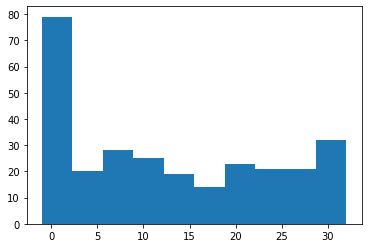

total number of topics 34
Pre topic adjustment
    Topic  Size
0      -1    63
7       6    13
31     30    12
28     27    11
12     11    11
16     15    10
5       4    10
30     29     9
8       7     9
25     24     8
topic 6
['stones', 'stone', 'vt', 'headaches', 'onset', 'po', 'syndrome', 'ruq', 'mm', 'cholecystitis', 'large', 'crampy', 'days', 'volume', 'stool', 'hernia', 'report', 'non', 'pericholecystic', 'positional']
topic 30
['il', 'lasix', 'therapy', 'melanoma', 'disease', 'rca', 'coronary', 'soft', 'dilantin', 'high', 'mr', 'groin', 'post', 'lung', 'subcutaneous', 'despite', 'erythema', 'dose', 'stenting', 'plts']
topic 27
['cpap', 'episode', 'wnl', 'swelling', 'weakness', 'vertigo', 'says', 'denied', 'better', 'yesterday', 'morning', 'hpi', 'pna', 'fevers', 'temperature', 'ros', 'sided', 'fatigue', 'diarrhea', 'pressors']
topic 11
['donor', 'transplant', 'aortic', 'diagnosed', 'cirrhosis', 'male', 'stenosis', 'liver', 'suitable', 'lasix', 'radiofrequency', 'dr', 'allo',

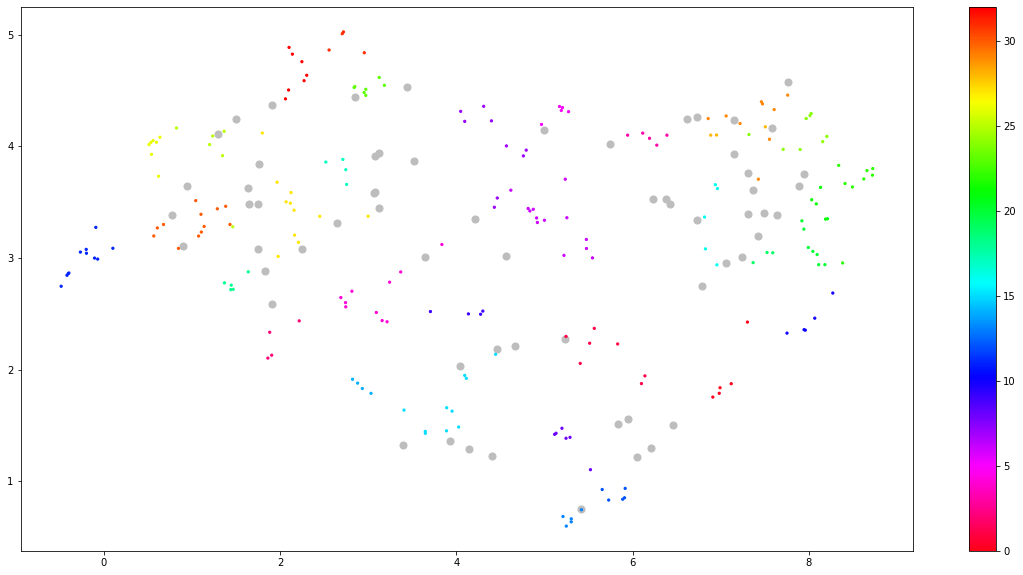

In [38]:
n_neighbors = 5
n_components = 5
min_cluster_size = 3
leaf_size = 10
tf_idf, docs_df, docs_per_topic, top_n_words, data_df = pipeline(data_df, embeddings, n_neighbors, n_components, min_cluster_size, leaf_size)

number of outliers 43
total number of topics 30


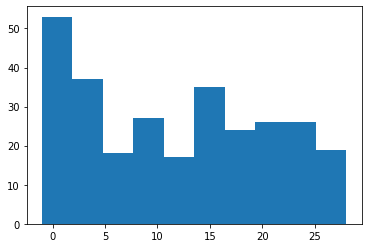

total number of topics 30
Pre topic adjustment
    Topic  Size
0      -1    43
3       2    23
9       8    16
17     16    15
20     19    14
15     14    12
21     20    11
29     28    10
24     23    10
22     21     9
topic 2
['tachycardia', 'ray', 'respiratory', 'hallucinations', 'device', 'sats', 'upper', 'control', 'pleural', 'antibiotics', 'leg', 'pericardial', 'neg', 'effusion', 'worsening', 'placed', 'recent', 'daily', 'vancomycin', 'lower']
topic 8
['seizure', 'woman', 'walking', 'vision', 'echocardiogram', 'ms', 'bowel', 'changes', 'vitals', 'micu', 'headache', 'heart', 'leukodystrophy', 'bg', 'pressure', 'habits', 'vomiting', 'years', 'frequency', 'sinus']
topic 16
['endometrial', 'cm', 'pelvic', 'cyst', 'measured', 'dialysis', 'female', 'rvr', 'ms', 'epo', 'sac', 'cul', 'surgical', 'laparotomy', 'discussed', 'clinic', 'yesterday', 'receiving', 'end', 'asymptomatic']
topic 19
['trach', 'vent', 'female', 'aneurysm', 'thoracics', 'tracheostomy', 'tracheal', 'percent', 'fail

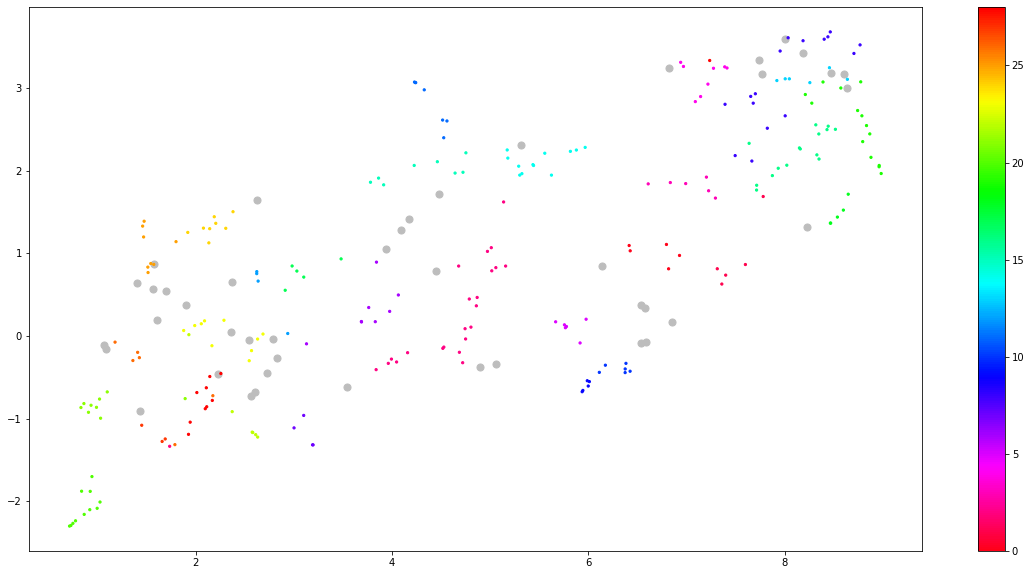

In [37]:
n_neighbors = 5
n_components = 5
min_cluster_size = 3
leaf_size = 15
tf_idf, docs_df, docs_per_topic, top_n_words, data_df = pipeline(data_df, embeddings, n_neighbors, n_components, min_cluster_size, leaf_size)

number of outliers 49
total number of topics 25


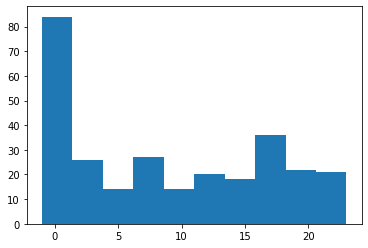

total number of topics 25
Pre topic adjustment
    Topic  Size
0      -1    49
1       0    24
9       8    22
4       3    21
18     17    21
16     15    14
20     19    12
2       1    11
22     21    11
21     20    10
topic 0
['tachycardia', 'ray', 'respiratory', 'hallucinations', 'device', 'sats', 'upper', 'worsening', 'control', 'placed', 'pleural', 'antibiotics', 'shortness', 'leg', 'neg', 'pericardial', 'initially', 'effusion', 'recent', 'daily']
topic 8
['gi', 'ercp', 'normal', 'hct', 'got', 'lobe', 'aspiration', 'change', 'rbc', 'egd', 'hickman', 'pneumonia', 'surgery', 'biliary', 'afib', 'transfer', 'epigastric', 'ischemic', 'anorexia', 'zosyn']
topic 3
['headaches', 'ercp', 'fatigued', 'ruq', 'stool', 'stones', 'stent', 'vt', 'stone', 'sunday', 'day', 'bradycardia', 'report', 'po', 'feeling', 'possible', 'non', 'ir', 'ducts', 'velcade']
topic 17
['eating', 'times', 'began', 'does', 'headache', 'getting', 'noticed', 'week', 'carotid', 'day', 'night', 'complain', 'weeks', 'f

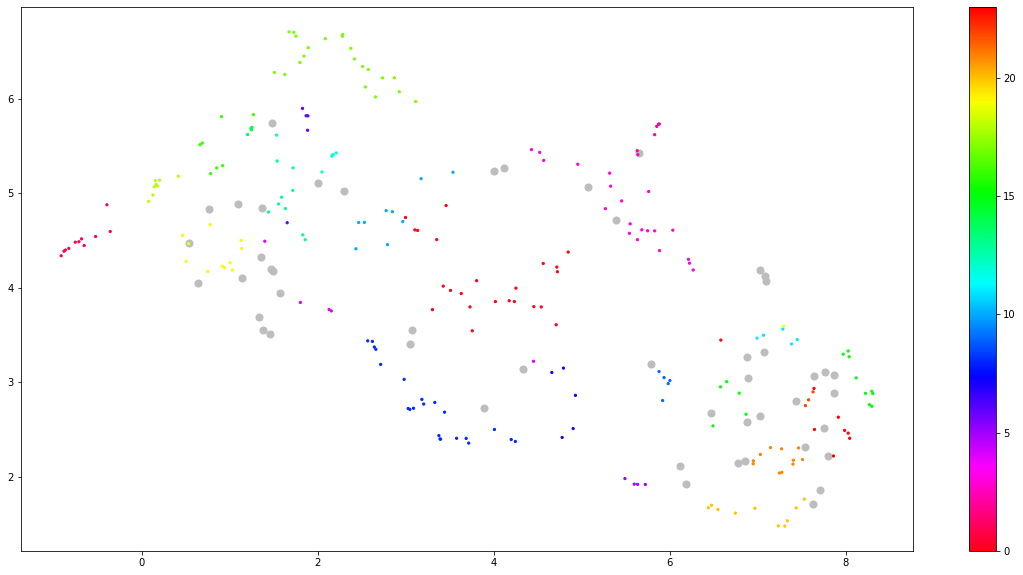

In [41]:
n_neighbors = 5
n_components = 5
min_cluster_size = 3
leaf_size = 10
tf_idf, docs_df, docs_per_topic, top_n_words, data_df = pipeline(data_df, embeddings, n_neighbors, n_components, min_cluster_size, leaf_size)

number of outliers 50
total number of topics 27


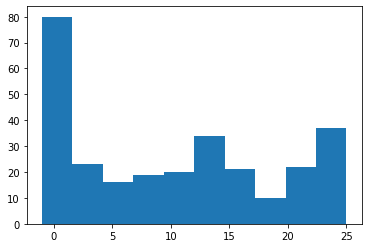

total number of topics 27
Pre topic adjustment
    Topic  Size
0      -1    50
2       1    26
25     24    26
12     11    15
18     17    13
23     22    12
5       4    12
15     14    12
14     13    11
13     12    11
topic 1
['rr', 'tachycardia', 'ray', 'respiratory', 'hallucinations', 'cc', 'device', 'sats', 'upper', 'control', 'pleural', 'antibiotics', 'htn', 'leg', 'neg', 'pericardial', 'initially', 'effusion', 'worsening', 'mg']
topic 24
['fall', 'trach', 'female', 'woman', 'daughter', 'ivf', 'notes', 'paroxysmal', 'fell', 'old', 'benadryl', 'year', 'time', 'doses', 'fibrillation', 'management', 'vent', 'fracture', 'wbc', 'ms']
topic 11
['ercp', 'lobe', 'gi', 'rbc', 'hickman', 'hct', 'biliary', 'afib', 'epigastric', 'zosyn', 'hypertensive', 'pneumonia', 'procedure', 'platelets', 'etoh', 'infections', 'drain', 'hypoxia', 'fluid', 'change']
topic 17
['il', 'lasix', 'therapy', 'melanoma', 'disease', 'rca', 'post', 'coronary', 'soft', 'dilantin', 'high', 'mr', 'groin', 'lung', 's

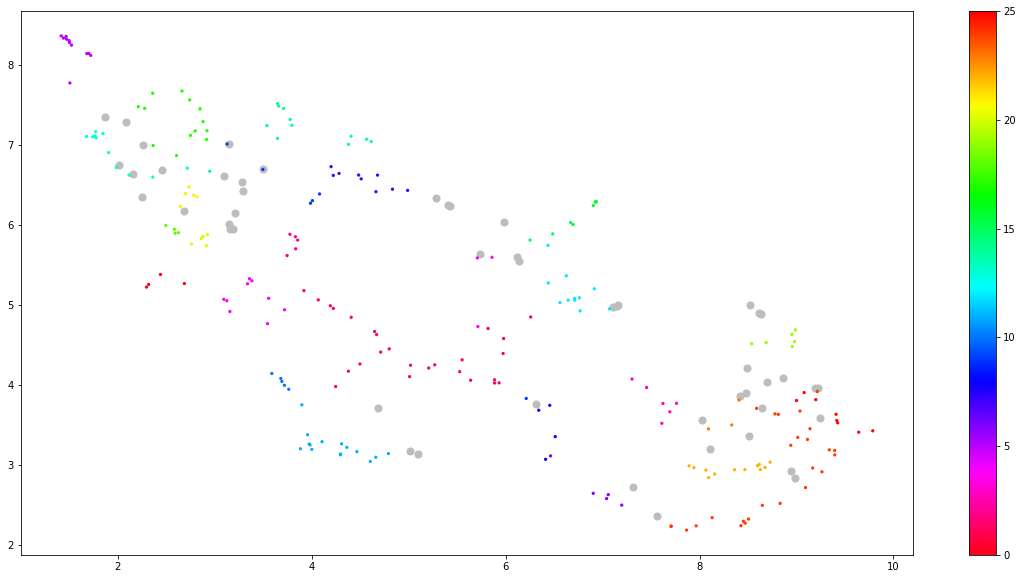

In [42]:
n_neighbors = 5
n_components = 5
min_cluster_size = 3
leaf_size = 10
tf_idf, docs_df, docs_per_topic, top_n_words, data_df = pipeline(data_df, embeddings, n_neighbors, n_components, min_cluster_size, leaf_size)

number of outliers 36
total number of topics 23


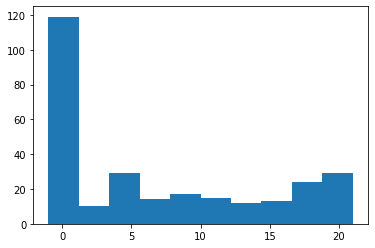

total number of topics 23
Pre topic adjustment
    Topic  Size
1       0    80
0      -1    36
5       4    25
18     17    17
10      9    13
22     21    11
17     16     9
21     20     9
20     19     9
7       6     9
topic 0
['female', 'woman', 'ms', 'daughter', 'cm', 'old', 'year', 'arrival', 'fall', 'ivf', 'seizure', 'dysuria', 'endometrial', 'noted', 'pressure', 'acute', 'bowel', 'past', 'right', 'changes']
topic 4
['tachycardia', 'ray', 'respiratory', 'hallucinations', 'cc', 'device', 'sats', 'rr', 'control', 'pleural', 'antibiotics', 'leg', 'pericardial', 'neg', 'initially', 'effusion', 'worsening', 'placed', 'recent', 'lower']
topic 17
['man', 'says', 'episode', 'bmt', 'chronic', 'called', 'cpap', 'steroids', 'verbal', 'ffp', 'weakness', 'hemorrhage', 'denied', 'swelling', 'wernicke', 'levofloxacin', 'ceftriaxone', 'years', 'bed', 'ems']
topic 9
['stones', 'stone', 'vt', 'headaches', 'onset', 'po', 'syndrome', 'ruq', 'mm', 'cholecystitis', 'large', 'crampy', 'days', 'volume

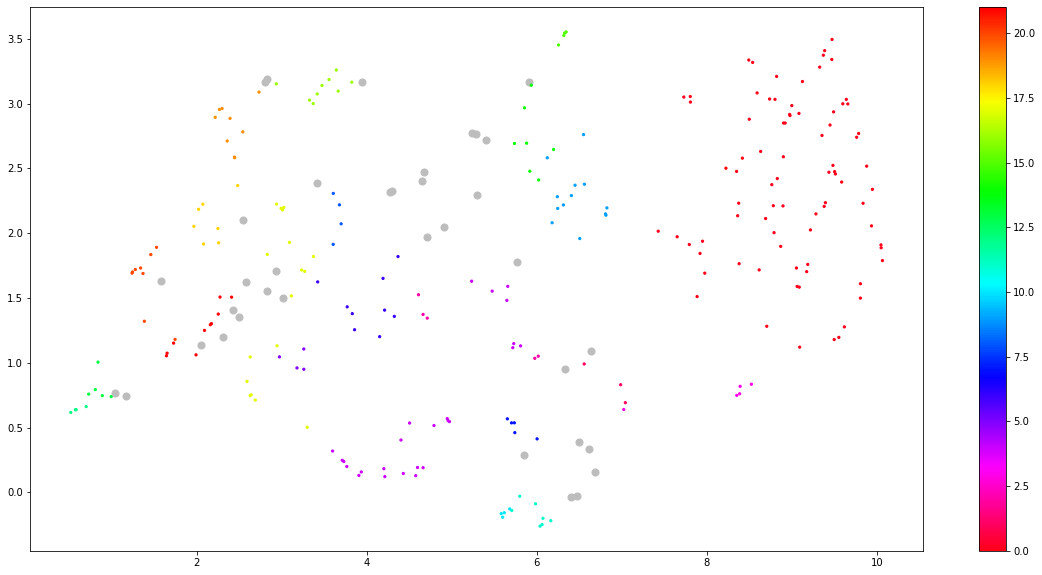

In [43]:
n_neighbors = 5
n_components = 5
min_cluster_size = 3
leaf_size = 10
tf_idf, docs_df, docs_per_topic, top_n_words, data_df = pipeline(data_df, embeddings, n_neighbors, n_components, min_cluster_size, leaf_size)